<a href="https://colab.research.google.com/github/mmilannaik/Data_Science/blob/master/Credit_Risk_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-risk-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1404394%2F2327131%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240706%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240706T061906Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3413d9dd3801cdb998f907259dc155384a9373ff1c962666e6c8b071330854dbdb14d63c046630dae842d83bc7fe0dad025a642a39ba98eb8e235deae595cf314a58d091976384ea4af5fe0e3b3baa15d3fc8712d0dc7d88938a824844a7de4d5a2060dbf5f389b30fa69ab6ae1d26cf6e01ec1465b6d3bab6adfd370ac9b6a30e988b490e2816ccfd3159ee016c9ad9f2719127f5ac088700c3d2f169387fc65aa0585f281748ef4ad3203c36fbc4fd8c295e50c5d2d26ba8f8b3aaaae464bf40eed27386268a0125753897e323ec3610e3c77b6339c27aafbb3e03f3db87333c7fde8767e5af7de877a0c9cf8999674d4dfa205f5b011366459414dfba74ec'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 106142650 bytes downloaded
Downloaded and uncompressed: credit-risk-dataset
Data source import complete.


<head><center><font size=6><b>
    Credit Risk Analysis
    </b></font></center></head>
<body><font size=3><p style="text-align: justify;">
    Credit risk analysis is an essential step in the credit granting process of financial institutions. Its purpose is to assess creditworthiness and identify the potential risks associated with lending. This notebook will discuss the steps and methodologies used in credit risk analysis, as well as the factors that need to be considered to make informed credit decisions.
    </font></body>
<center><img src="https://static.vecteezy.com/system/resources/previews/001/373/061/non_2x/hand-holding-credit-card-top-view-free-photo.jpg" width="511" height="338">

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix

In [4]:
# Importing our data
df = pd.read_csv("/kaggle/input/credit-risk-dataset/loan/loan.csv",index_col=0)

In [5]:
pd.options.display.max_columns = None

## 1. Data Understanding
### 1.1 Summary :
- The dataset has 887,379 rows and 73 columns.
- There are 50 numerical columns and 23 categorical columns.
- Approximately 20 columns have missing values greater than 70%.
- The average budgeted amount is nearly equal to the amount borrowed.
- The average loan interest rate is 13.24%, which is quite large
- There are 5 columns in date format, which are 'issue_d', 'last_pymnt_d','next_pymnt_d' earliest_cr_line', and last_credit_pull_d'.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 887379 entries, 1077501 to 36271262
Data columns (total 73 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   member_id                    887379 non-null  int64  
 1   loan_amnt                    887379 non-null  float64
 2   funded_amnt                  887379 non-null  float64
 3   funded_amnt_inv              887379 non-null  float64
 4   term                         887379 non-null  object 
 5   int_rate                     887379 non-null  float64
 6   installment                  887379 non-null  float64
 7   grade                        887379 non-null  object 
 8   sub_grade                    887379 non-null  object 
 9   emp_title                    835917 non-null  object 
 10  emp_length                   842554 non-null  object 
 11  home_ownership               887379 non-null  object 
 12  annual_inc                   887375 non-null  float64
 

In [7]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
count,8.873790e+05,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,8.873750e+05,887379.000000,887350.000000,887350.000000,433067.000000,137053.000000,887350.000000,887350.000000,8.873790e+05,886877.000000,887350.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887379.000000,887234.000000,221703.000000,887379.0,511.000000,509.000000,887350.000000,8.171030e+05,8.171030e+05,21372.000000,21372.000000,21372.000000,21372.000000,20810.000000,21372.000000,18617.000000,21372.000000,21372.000000,21372.000000,21372.000000,8.171030e+05,21372.000000,21372.000000,21372.000000
mean,3.500182e+07,14755.264605,14741.877625,14702.464383,13.246740,436.717127,7.502759e+04,18.157039,0.314442,0.694623,34.063798,70.117903,11.548469,0.195307,1.692079e+04,55.067693,25.268026,8403.124852,8399.713242,7558.826684,7521.160306,5757.706424,1754.804327,0.396692,45.919243,4.880757,2164.145585,0.014380,44.104838,1.0,109981.011585,18.310118,0.004991,2.257026e+02,1.394582e+05,1.109021,2.928832,0.761651,1.674574,20.912686,36552.811389,71.535317,1.389060,2.975482,5887.979740,60.831939,3.206862e+04,0.943945,1.537058,1.977307
std,2.411335e+07,8435.455601,8429.897657,8442.106732,4.381867,244.186593,6.469830e+04,17.190626,0.862244,0.998448,21.884940,28.127914,5.317313,0.582091,2.242679e+04,23.834344,11.840561,8493.450269,8489.997617,7871.243336,7846.108604,6625.441046,2095.356099,4.087825,409.693874,63.125281,4794.783233,0.134191,22.179841,0.0,52730.379847,7.169233,0.077625,1.031137e+04,1.537500e+05,1.242675,3.089987,0.996035,1.688725,27.209081,43103.833619,23.022862,1.520129,2.631886,5284.701239,20.013254,3.749826e+04,1.446872,2.723339,2.874067
min,7.047300e+04,500.000000,500.000000,0.000000,5.320000,15.670000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,17950.000000,3.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,-4.000000
25%,1.087713e+07,8000.000000,8000.000000,8000.000000,9.990000,260.705000,4.500000e+04,11.910000,0.000000,0.000000,15.000000,51.000000,8.000000,0.000000,6.443000e+03,37.700000,17.000000,0.000000,0.000000,1914.590000,1899.700000,1200.570000,441.460000,0.000000,0.000000,0.000000,280.170000,0.000000,27.000000,1.0,76032.500000,13.200000,0.000000,0.000000e+00,2.985300e+04,0.000000,1.000000,0.000000,0.000000,6.000000,10251.500000,58.600000,0.000000,1.000000,2411.000000,47.700000,1.390000e+04,0.000000,0.000000,0.000000
50%,3.709528e+07,13000.000000,13000.000000,13000.000000,12.990000,382.550000,6.500000e+04,17.650000,0.000000,0.000000,31.000000,70.000000,11.000000,0.000000,1.187500e+04,56.000000,24.000000,6458.290000,6455.810000,4894.999117,4862.010000,3215.320000,1073.280000,0.000000,0.000000,0.000000,462.780000,0.000000,44.000000,1.0,101771.000000,17.610000,0.000000,0.000000e+00,8.055900e+04,1.000000,2.000000,0.000000,1.000000,12.000000,24684.500000,74.900000,1.000000,2.000000,4483.000000,61.900000,2.370000e+04,0.000000,0.000000,2.000000
75%,5.847135e+07,20000.000000,20000.000000,20000.000000,16.2

In [8]:
df.head(3)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-1985,1.0,NaN,NaN,3.0,0.0,13648.0,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,Jan-2015,171.62,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-1999,5.0,NaN,NaN,3.0,0.0,1687.0,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,Apr-2013,119.66,NaN,Sep-2013,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,Jun-2014,649.91,NaN,Jan-2016,0.0,NaN,1.0,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Check missing values in the dataset
missing_values_per_column = (df.isnull().sum() / len(df)) * 100
columns_to_drop = missing_values_per_column[missing_values_per_column > 70].index
columns_to_drop

Index(['desc', 'mths_since_last_record', 'mths_since_last_major_derog',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'inq_fi', 'total_cu_tl',
       'inq_last_12m'],
      dtype='object')

In [10]:
filtered_data = df.drop(columns_to_drop,axis=1)

In [11]:
categorical_data = filtered_data.select_dtypes(include=['object'])
categorical_data.head(3)

,term,grade,sub_grade,emp_title,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
id,,,,,,,,,,,,,,,,,,,,,
1077501,36 months,B,B2,NaN,10+ years,RENT,Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,credit_card,Computer,860xx,AZ,Jan-1985,f,Jan-2015,NaN,Jan-2016,INDIVIDUAL
1077430,60 months,C,C4,Ryder,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,car,bike,309xx,GA,Apr-1999,f,Apr-2013,NaN,Sep-2013,INDIVIDUAL
1077175,36 months,C,C5,NaN,10+ years,RENT,Not Verified,Dec-2011,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,small_business,real estate business,606xx,IL,Nov-2001,f,Jun-2014,NaN,Jan-2016,INDIVIDUAL


In [12]:
categorical_data.nunique()

term                        2
grade                       7
sub_grade                  35
emp_title              299271
emp_length                 11
home_ownership              6
verification_status         3
issue_d                   103
loan_status                10
pymnt_plan                  2
url                    887379
purpose                    14
title                   63143
zip_code                  935
addr_state                 51
earliest_cr_line          697
initial_list_status         2
last_pymnt_d               98
next_pymnt_d              100
last_credit_pull_d        103
application_type            2
dtype: int64

In [13]:
# Columns that have too many unique values will be dropped
cat_drop = ['url','emp_title','title','zip_code','sub_grade']
categorical_data.drop(cat_drop,axis=1,inplace=True)
categorical_data.head(3)

,term,grade,emp_length,home_ownership,verification_status,issue_d,loan_status,pymnt_plan,purpose,addr_state,earliest_cr_line,initial_list_status,last_pymnt_d,next_pymnt_d,last_credit_pull_d,application_type
id,,,,,,,,,,,,,,,,
1077501,36 months,B,10+ years,RENT,Verified,Dec-2011,Fully Paid,n,credit_card,AZ,Jan-1985,f,Jan-2015,NaN,Jan-2016,INDIVIDUAL
1077430,60 months,C,< 1 year,RENT,Source Verified,Dec-2011,Charged Off,n,car,GA,Apr-1999,f,Apr-2013,NaN,Sep-2013,INDIVIDUAL
1077175,36 months,C,10+ years,RENT,Not Verified,Dec-2011,Fully Paid,n,small_business,IL,Nov-2001,f,Jun-2014,NaN,Jan-2016,INDIVIDUAL


In [14]:
numerical_data = filtered_data.select_dtypes(include=['int64','float64'])
numerical_data.head(3)

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1077501,1296599,5000.0,5000.0,4975.0,10.65,162.87,24000.0,27.65,0.0,1.0,NaN,3.0,0.0,13648.0,83.7,9.0,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.0,0.00,0.00,171.62,0.0,1.0,0.0,NaN,NaN,NaN
1077430,1314167,2500.0,2500.0,2500.0,15.27,59.83,30000.0,1.00,0.0,5.0,NaN,3.0,0.0,1687.0,9.4,4.0,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.0,117.08,1.11,119.66,0.0,1.0,0.0,NaN,NaN,NaN
1077175,1313524,2400.0,2400.0,2400.0,15.96,84.33,12252.0,8.72,0.0,2.0,NaN,2.0,0.0,2956.0,98.5,10.0,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.0,0.00,0.00,649.91,0.0,1.0,0.0,NaN,NaN,NaN


In [15]:
# since member_id is the identity for each entry and policy code only has one value, these column are removed
numerical_data.drop(['member_id','policy_code'],axis=1,inplace=True)

In [16]:
new_df = pd.concat([numerical_data,categorical_data],axis=1)

### 1.2 Bad Borrower vs Good Borrower
##### Good Borrowers:

- Fully Paid: These borrowers have completely repaid their loans on time. This indicates a good credit history and responsible borrowing behavior.
- Current: These borrowers are currently making their loan payments on time. While not a complete repayment yet, it shows they are meeting their current obligations.
- In Grace Period: Borrowers in the grace period are slightly late on their payments but typically have a short window (around 15 days) to catch up without penalty. This might be due to a temporary setback and doesn't necessarily reflect poorly on their creditworthiness.

##### Bad Borrowers:

- Charged Off: The lender has written off the loan as a loss because the borrower is unlikely to repay it. This is a severe delinquency and indicates a high credit risk.
- Default: The borrower has failed to make their loan payments for a certain period (usually 90 days or more). This is a serious delinquency that can significantly damage a borrower's credit score.
- Late (16-30 days) / Late (31-120 days): These borrowers are late on their repayments by varying degrees. Even a single late payment can negatively impact their credit score, and habitual late payments are a sign of potential credit problems.
- Does not meet the credit policy. Status: Fully Paid / Does not meet the credit policy. Status: Charged Off: These borrowers did not meet the lender's creditworthiness standards when initially issued the loan but eventually repaid it (Fully Paid) or defaulted (Charged Off). Despite the eventual repayment (Fully Paid), not meeting the credit policy initially suggests a higher credit risk.
- Issued: The loan status is simply "Issued" and doesn't provide enough information to determine the borrower's repayment behavior. It's best to exclude this category until there's a history of repayments.

In [17]:
new_df['loan_status'].unique()

array(['Fully Paid', 'Charged Off', 'Current', 'Default',
       'Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)',
       'Does not meet the credit policy. Status:Fully Paid',
       'Does not meet the credit policy. Status:Charged Off', 'Issued'],
      dtype=object)

In [18]:
# Define the mapping for desired values (1 for good status, 0 for others)
mapping = {'Fully Paid': 1, 'Current': 1, 'In Grace Period': 1,
           'Charged Off': 0, 'Default': 0, 'Late (31-120 days)': 0,
           'Late (16-30 days)': 0,
           'Does not meet the credit policy. Status:Fully Paid': 0,
           'Does not meet the credit policy. Status:Charged Off': 0,
           'Issued': 0}
# Create a new column for the transformed data
new_df['loan_status'] = new_df['loan_status'].replace(mapping)

### 1.3 Detecting Outlier
- As many as 27 of the 31 numerical columns have outliers above the upper whisker.
- The distribution is heavily skewed to the left, indicating that most of the values are concentrated in the lower range. Consider transforming the data to reduce skewness
- In the 'dti' and 'revol_util' columns there are outliers that are significantly different from other data. It is possible that this is an error value so consider deleting it.

In [19]:
def detect_outlier(column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    for entry in df[column_name]:
        if entry > upper_whisker or entry < lower_whisker :
            return 'YES'
    return 'NO'

In [20]:
numerical_cols = new_df.select_dtypes(include=['int64','float64'])
numerical_cols = numerical_cols.drop('loan_status',axis=1) # exclude target variable
outlier_cols = []
for col in numerical_cols.columns:
    if detect_outlier(col)=='YES':
        outlier_cols.append(col)

In [21]:
# Find columns with outliers
outlier_cols

['int_rate',
 'installment',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'mths_since_last_delinq',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'out_prncp',
 'out_prncp_inv',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_pymnt_amnt',
 'collections_12_mths_ex_med',
 'acc_now_delinq',
 'tot_coll_amt',
 'tot_cur_bal',
 'total_rev_hi_lim']

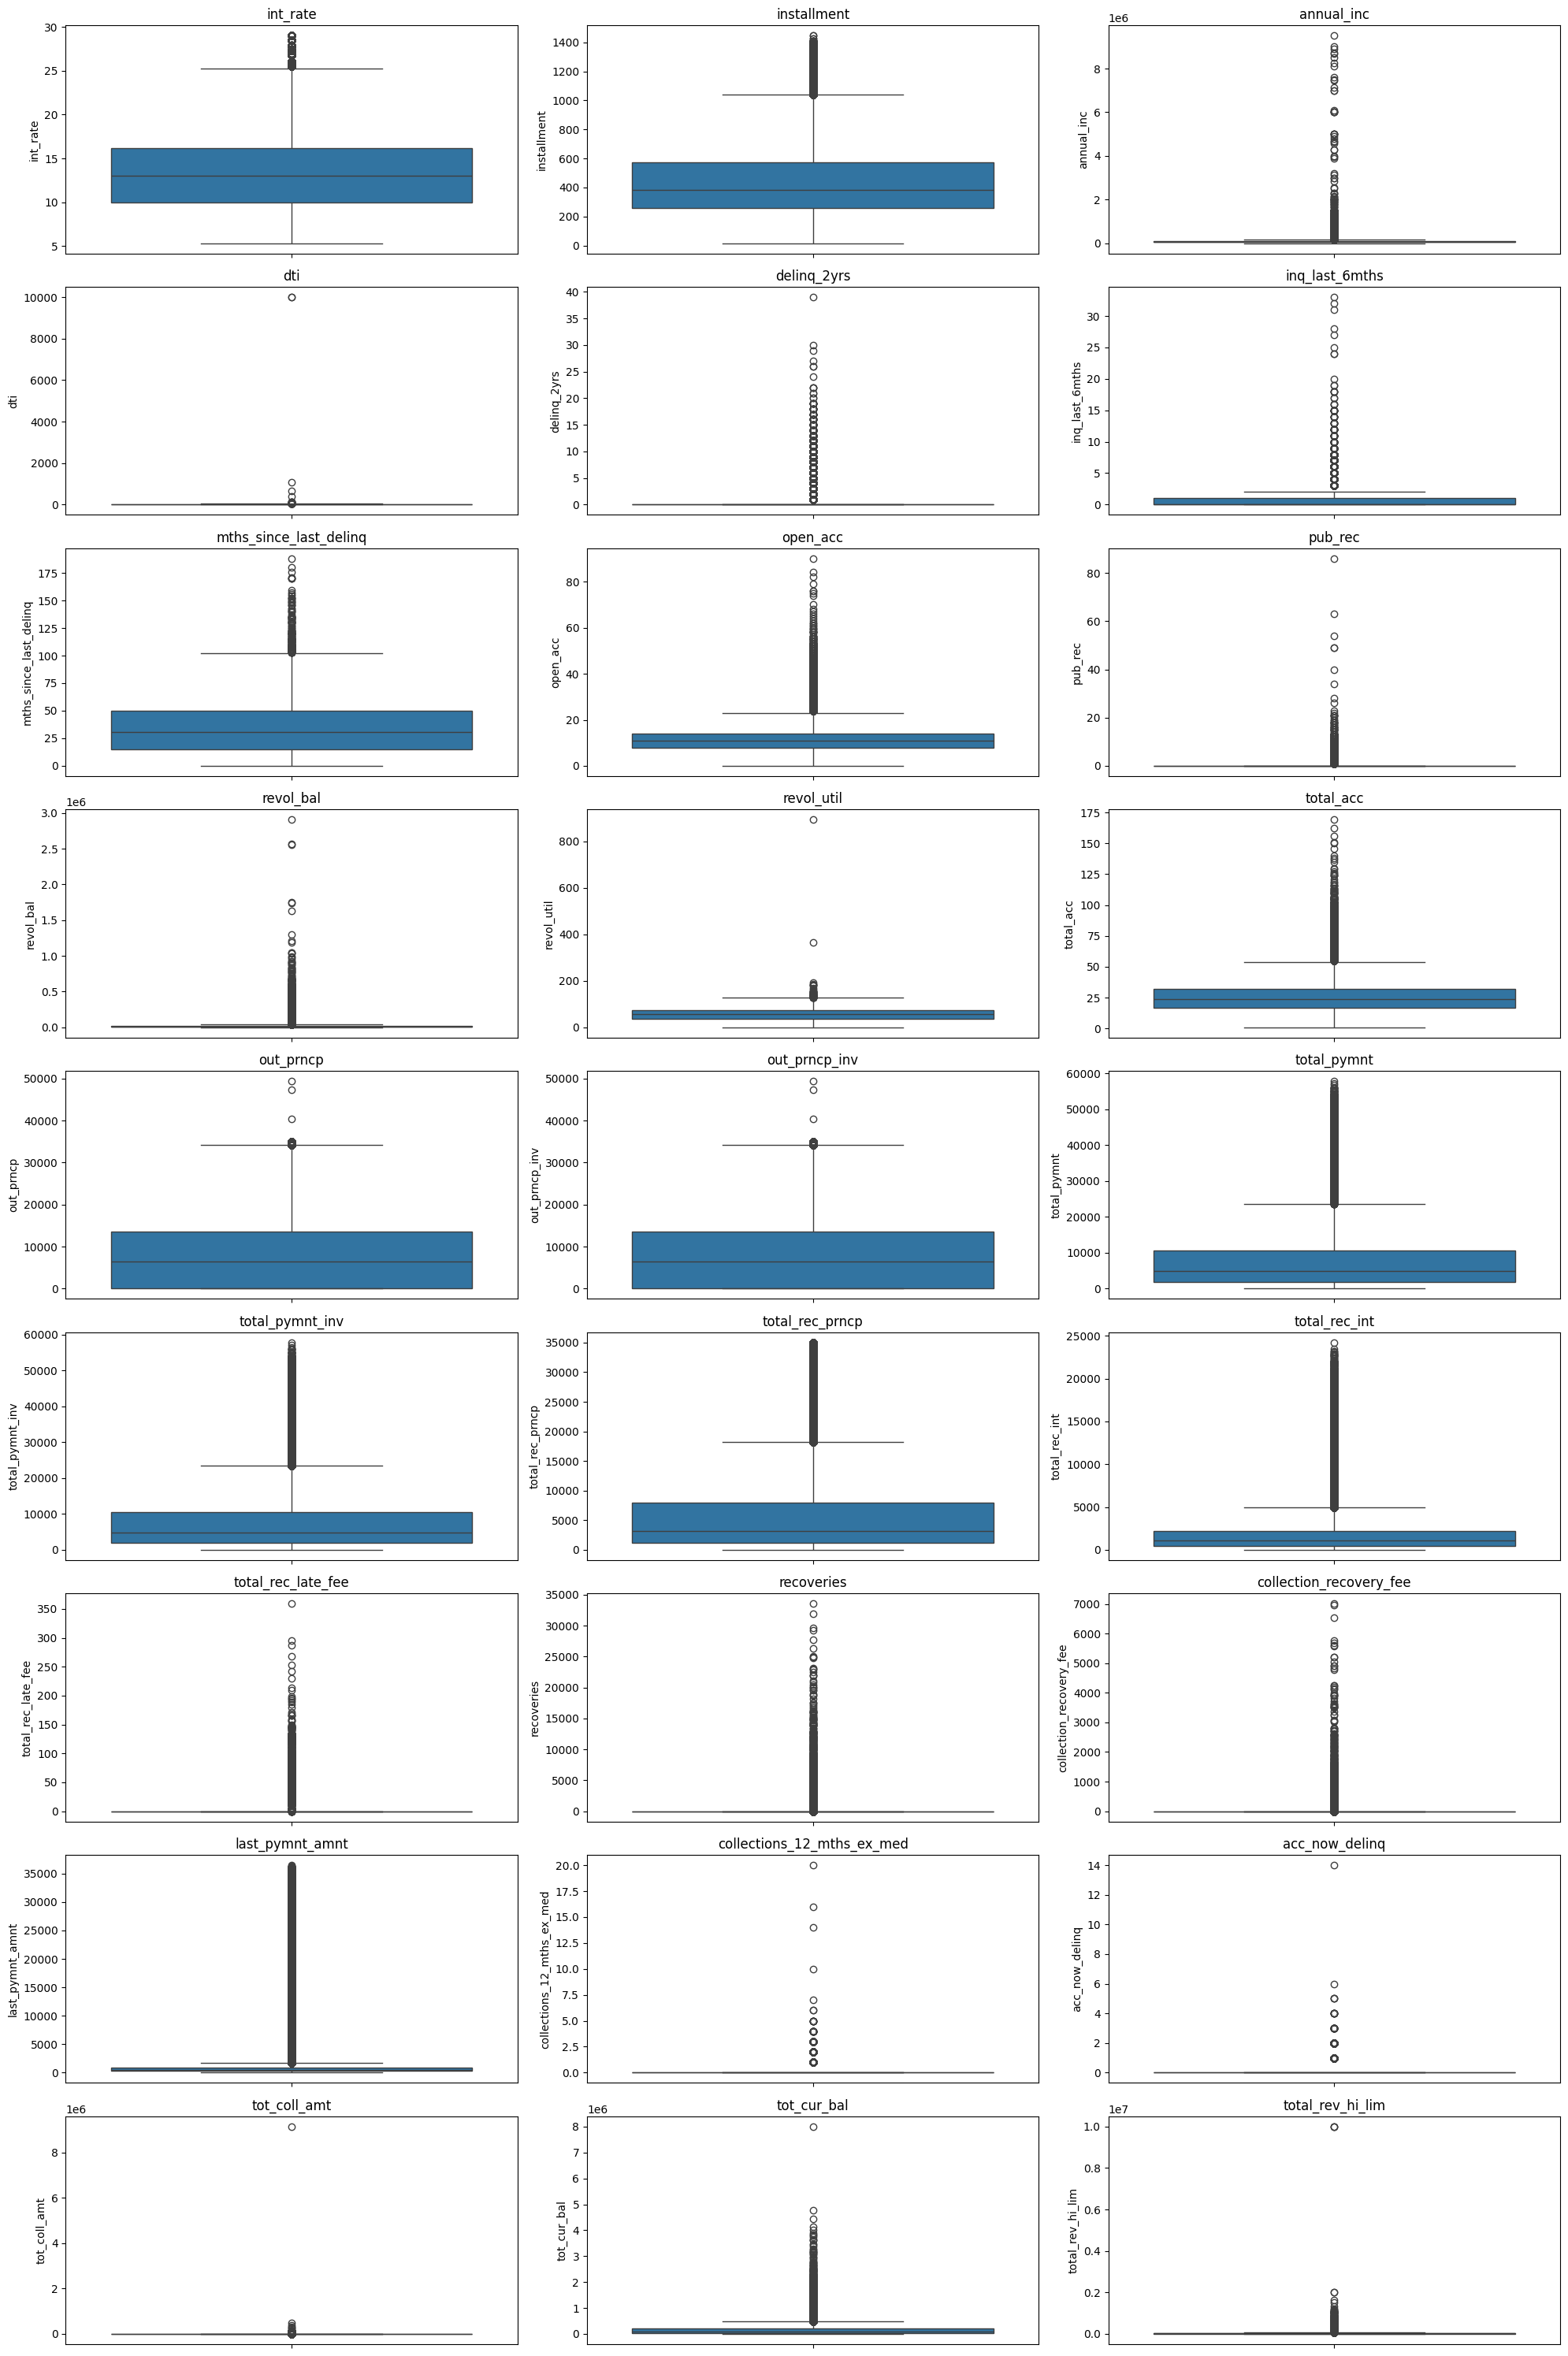

In [22]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(20, 30))
for i, ax in enumerate(axes.flat):
    if i < len(outlier_cols):
        column_name = outlier_cols[i]
        sns.boxplot(y=column_name, data=new_df, ax=ax)
        ax.set_title(column_name)
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(20, 30))
for i, ax in enumerate(axes.flat):
    if i < len(outlier_cols):
        column_name = outlier_cols[i]
        sns.histplot(x=column_name, data=new_df, ax=ax)
        ax.set_title(column_name)
plt.tight_layout()

In [ ]:
# Delete error value in 'dti'
new_df.drop(new_df[new_df['dti'] > 8000].index, inplace=True)

In [ ]:
# Delete error value in 'revol_util'
new_df.drop(new_df[new_df['revol_util'] > 300].index, inplace=True)

#### 1.4 Exploratory Data Analysis
- The bar chart shows that people who borrow for education, small businesses, or weddings who have larger than average revolving balances have a higher risk.
- The average monthly payments that borrowers must pay appear to be higher for lower classes. However, they have the same risk tendencies.
- Most loan funds are spread across California, Texas, New York, and Florida.
- The total amount committed by high-risk borrowers is less than the amount applied for a loan.


In [ ]:
sns.barplot(
    x="revol_bal",y="purpose",
    hue="loan_status", data=new_df,
    width=0.7 ,dodge=True,
    orient='h'
)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

In [ ]:
sns.barplot(
    x='grade',y='installment', hue='loan_status',
    data=new_df, order=['A','B','C','D','E','F','G']
)
plt.grid()

In [ ]:
plt.figure(figsize=(10,10))
sns.barplot(
    x='addr_state',y='loan_amnt',
    estimator='sum', data=new_df,
    width=0.8, dodge=True
)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()

In [ ]:
plt.figure(figsize=(6,6))
sns.scatterplot(x='loan_amnt',y='total_pymnt',hue='loan_status',data=new_df)

In [ ]:
corr_df = new_df.select_dtypes(include=['int','float']).corr()
plt.figure(figsize=(8,8))
sns.heatmap(corr_df,vmin=-1,vmax=1,cmap='jet')

Some features have high correlation. These features can cause overfitting in the model. To prevent this from happening, one of the feature pairs is removed from the dataset

In [ ]:
upper = corr_df.abs().where(np.triu(np.ones(corr_df.shape), k=1).astype(np.bool_))
to_drop_hicorr = [column for column in upper.columns if any(upper[column] > 0.7)]

In [ ]:
to_drop_hicorr

In [ ]:
new_df.drop(to_drop_hicorr, axis=1, inplace=True)

## 2. Data Preparation

### 2.1 Data Formatting
- Data that should be numeric but in the dataframe is in string form because it has units is changed to just numbers by removing the units, ex: '36 months' -> 36

In [ ]:
new_df['term'] = new_df['term'].str.replace(r"[^\d+]", "", regex=True)
new_df['term'] = pd.to_numeric(new_df['term'], errors='coerce')
new_df['term'].astype(int)

In [ ]:
new_df['emp_length'] = new_df['emp_length'].replace(to_replace='10+ years',value=10)
new_df['emp_length'] = new_df['emp_length'].replace(to_replace='< 1 year',value=0)
new_df['emp_length'] = new_df['emp_length'].replace(to_replace='.years',value='',regex=True)
new_df['emp_length'] = new_df['emp_length'].replace(to_replace='.year',value='',regex=True)
new_df['emp_length'].astype('float')

### 2.2 Train Test Split

In [ ]:
X = new_df.drop('loan_status',axis=1)
y = new_df['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,stratify=y)

### 2.3 Imputation

In [ ]:
num_cols = X.select_dtypes(include=['int','float']).columns # Numerical columns
cat_cols = X.select_dtypes(include='object').columns # Categorical columns

# Impute missing values in numerical features (using median strategy)
imputer_numerical = SimpleImputer(strategy='median')
imputer_numerical.fit(X_train[num_cols])
X_train[num_cols] = imputer_numerical.transform(X_train[num_cols])
X_test[num_cols] = imputer_numerical.transform(X_test[num_cols])

# Impute missing values in categorical features (using most_frequent strategy)
imputer_categorical = SimpleImputer(strategy='most_frequent')
imputer_categorical.fit(X_train[cat_cols])
X_train[cat_cols] = imputer_categorical.transform(X_train[cat_cols])
X_test[cat_cols] = imputer_categorical.transform(X_test[cat_cols])

Now we have X_train and X_test with imputed missing values for both numerical and categorical features

### 2.3 Parsing Dates

In [ ]:
X_train[cat_cols].head()

Some columns have values in the form of dates. However, Python does not know that the data is a date but an object

In [ ]:
date_cols = ['issue_d','earliest_cr_line','last_pymnt_d','next_pymnt_d','last_credit_pull_d']
for col in date_cols:
    X_train[col] = pd.to_datetime(X_train[col], format='%b-%Y')
    X_test[col] = pd.to_datetime(X_test[col], format='%b-%Y')

In [ ]:
X_train[date_cols]

The 'last_pymnt_d' column and the 'last_credit_pull_d' column seem appear to have many of the same dates. Let's check the correlation of these columns. If it is more than 70%, consider to remove one of them.

In [ ]:
X_train[['last_pymnt_d','last_credit_pull_d']].corr()

In [ ]:
X_train.drop('last_credit_pull_d',axis=1,inplace=True)
X_test.drop('last_credit_pull_d',axis=1,inplace=True)

Due to machine learning model that will be used require numerical value, all not numerical value need to convert to numerical value. In this instance, all event dates must be changed to reflect the issue date.

In [ ]:
X_train['earliest_cr_line_D'] = X_train['issue_d'] - X_train['earliest_cr_line']
X_test['earliest_cr_line_D'] = X_test['issue_d'] - X_test['earliest_cr_line']

X_train['last_pymnt_d_D'] = X_train['last_pymnt_d'] - X_train['issue_d']
X_test['last_pymnt_d_D'] = X_test['last_pymnt_d'] - X_test['issue_d']

X_train['next_pymnt_d_D'] = X_train['next_pymnt_d'] - X_train['issue_d']
X_test['next_pymnt_d_D'] = X_test['next_pymnt_d'] - X_test['issue_d']

In [ ]:
X_train.drop(X_train.select_dtypes(include='datetime').columns,axis=1,inplace=True)
X_test.drop(X_test.select_dtypes(include='datetime').columns,axis=1,inplace=True)

In [ ]:
# convert timedelta datatype into integer datatype
time_delta_cols = X_train.select_dtypes(include='timedelta').columns
for col in time_delta_cols:
    X_train[col] = X_train[col].dt.days
    X_test[col] = X_test[col].dt.days

### 2.4 Encoding

In [ ]:
cat_cols = X_train.select_dtypes(include='object').columns
X_train[cat_cols].nunique()

In [ ]:
col_to_check = [
    'home_ownership','verification_status',
    'pymnt_plan','initial_list_status',
    'application_type'
]
for col in col_to_check:
    print(X_train[col].value_counts())
    print('')

- The 'grade' column is encoded with OrdinalEncoder because it is multilevel data.
- The 'purpose','addr_state', and 'home_ownership' column is encoded with LabelEncoder
- The 'application_type' column and the 'pymnt_plan' column are considered for deletion because they are dominated by only one value.
- Meanwhile, the other columns are simply encoded with OneHotEncoder.

In [ ]:
X_train.drop(['application_type','pymnt_plan'],axis=1,inplace=True)
X_test.drop(['application_type','pymnt_plan'],axis=1,inplace=True)

If there are values in the test data that are not present in the training data, the encoder will generate an error. We must therefore check them. We can move on to the next stage as long as there are no columns that are stuck.

In [ ]:
cat_cols = X_train.select_dtypes(include='object').columns
good_label_cols = [col for col in cat_cols if set(X_test[col]).issubset(set(X_train[col]))]
bad_label_cols = list(set(cat_cols)-set(good_label_cols))
bad_label_cols

In [ ]:
# Ordinal Encoder
ordinal_enc = OrdinalEncoder()
X_train['grade_enc'] = ordinal_enc.fit_transform(X_train[['grade']])
X_test['grade_enc'] = ordinal_enc.transform(X_test[['grade']])

In [ ]:
# Label Encoder
label_enc = LabelEncoder()
X_train['home_ownership_enc'] = label_enc.fit_transform(X_train[['home_ownership']])
X_test['home_ownership_enc'] = label_enc.transform(X_test[['home_ownership']])
X_train['purpose_enc'] = label_enc.fit_transform(X_train[['purpose']])
X_test['purpose_enc'] = label_enc.transform(X_test[['purpose']])
X_train['addr_state_enc'] = label_enc.fit_transform(X_train[['addr_state']])
X_test['addr_state_enc'] = label_enc.transform(X_test[['addr_state']])

In [ ]:
# One-Hot Encoder
one_hot_enc = OneHotEncoder(sparse=False)
initial_list_status_train = pd.DataFrame(one_hot_enc.fit_transform(X_train[['initial_list_status']]),columns=one_hot_enc.get_feature_names_out())
initial_list_status_test = pd.DataFrame(one_hot_enc.transform(X_test[['initial_list_status']]),columns=one_hot_enc.get_feature_names_out())
verification_status_train = pd.DataFrame(one_hot_enc.fit_transform(X_train[['verification_status']]),columns=one_hot_enc.get_feature_names_out())
verification_status_test = pd.DataFrame(one_hot_enc.transform(X_test[['verification_status']]),columns=one_hot_enc.get_feature_names_out())

In [ ]:
initial_list_status_train.index = X_train.index
initial_list_status_test.index = X_test.index
verification_status_train.index = X_train.index
verification_status_test.index = X_test.index

In [ ]:
cat_cols = list(set(cat_cols) - set(['emp_length']))
X_train.drop(cat_cols,axis=1,inplace=True)
X_test.drop(cat_cols,axis=1,inplace=True)

In [ ]:
X_train_enc = pd.concat([X_train,verification_status_train,initial_list_status_train],axis=1)
X_test_enc = pd.concat([X_test,verification_status_test,initial_list_status_test],axis=1)

### 2.5 Standardization

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_test.columns)

## 3. Modelling

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clf = RandomForestClassifier(n_estimators=80, class_weight='balanced',random_state=10)

In [ ]:
clf.fit(X_train_scaled,y_train)

## 4. Evaluation

In [ ]:
y_pred = clf.predict(X_test_scaled)

In [ ]:
print(f"recall : {recall_score(y_test,y_pred)}")
print(f"precision : {precision_score(y_test,y_pred)}")
print(f"f1 : {f1_score(y_test,y_pred)}")

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_scaled, y_test,values_format='.0f')

By f1_score, the model seems good, but when we look at the false positive in the confusion matrix, the model is terrible. About more than half of high-risk borrowers are determined to be low-risk borrowers. This is a serious problem for LC, and it can be a big trade-off.

### 4.1 Over Sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=10)

In [ ]:
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled,y_train)

In [ ]:
clf.fit(X_train_resampled,y_train_resampled)

In [ ]:
y_pred_new = clf.predict(X_test_scaled)

In [ ]:
print(f"recall : {recall_score(y_test,y_pred_new)}")
print(f"precision : {precision_score(y_test,y_pred_new)}")
print(f"f1 : {f1_score(y_test,y_pred_new)}")

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    clf, X_test_scaled, y_test,values_format='.0f')

We can improve the model's performance in predicting high-risk borrowers. However, in return the performance in predicting positive values is reduced. This may not sound good, but it is certainly better than classifying more high-risk borrowers as low-risk borrowers. To go further, the model can be improved to achieve greater profits. One step that might really need to be tried is a cost-sensitive classifier. A better model will certainly bring more profits to the company. Therefore, aspects that have a high impact, such as false positives in this case, need to be considered more deeply.